# Build training set from image list

Training set is build from collection of images with marked object position (Metadata in plates.csv).

For each image:
 * Select randomly 10 subimages with size = (512, 256)
 * If license plate is on the image then save it as positie example, otherwise as negative.
 * Save positive and negative examples into 2 different folders

In [114]:
import os.path
import time
import random
import warnings
import numpy as np
import pandas as pd
import skimage
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from pylab import rcParams
%matplotlib inline

INPUT_FOLDER = '../../data/piotr/2016-08-27/'
OUPUT_FOLDER = '../../data/classifier/'

## Load image metadata

Normalize plate position

In [2]:
plates = pd.read_csv(INPUT_FOLDER + 'plates.csv').dropna()
plates['x1'] = plates[['left', 'right']].min(axis=1)
plates['x2'] = plates[['left', 'right']].max(axis=1)
plates['y1'] = plates[['top', 'bottom']].min(axis=1)
plates['y2'] = plates[['top', 'bottom']].max(axis=1)
ws = plates.x2-plates.x1
hs = plates.y2-plates.y1
print('Average width: {}, height: {}'.format(ws.mean(), hs.mean()))

Average width: 279.81236673773986, height: 77.11087420042644


## Show sample image with plate position

[367 543 693 613]


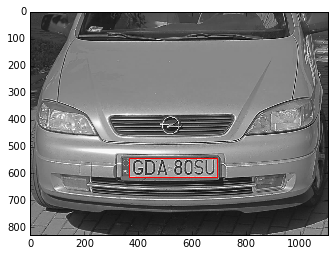

In [28]:
from skimage import io

def plot_record(img, pos):
    plt.gray()
    print(pos)
    rect = Rectangle((pos[0], pos[1]), pos[2]-pos[0], pos[3]-pos[1], edgecolor='r', fill=False)
    plt.imshow(img / 256.)
    gca = plt.gca()
    gca.add_patch(rect)
    plt.show()
    
row = plates.sample()
image_color = skimage.io.imread(INPUT_FOLDER + row.values[0][0])
image_gray = skimage.color.rgb2gray(image_color)
plot_record(image_gray, row[['x1', 'y1', 'x2', 'y2']].values[0])

## Preapre function for extracting regions

[280, 428, 792, 684]


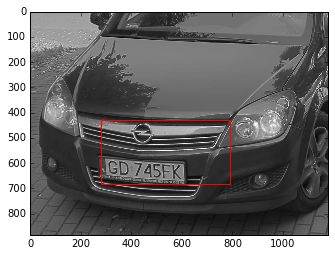

10

In [103]:
def is_in(rect1, rect2):
    """True if rect2 is inside rect 1"""
    return rect2[0] > rect1[0] and rect2[0] < rect1[2] and rect2[2] > rect1[0] and rect2[2] < rect1[2] and \
           rect2[1] > rect1[1] and rect2[1] < rect1[3] and rect2[3] > rect1[1] and rect2[3] < rect1[3] 
    
def is_outside(rect1, rect2):
    """True if rect2 is outside rect 1"""
    return rect2[0] > rect1[2] or rect2[2] < rect1[0] or rect2[1] > rect1[3] or rect2[3] < rect1[1]
    
def find_negatives(image):
    pos = image[['x1', 'y1', 'x2', 'y2']].values
    negatives = []
    width = image_gray.shape[1]
    height = image_gray.shape[0]
    for i in range(width-512):
        for j in range(height-256):
            if i % 50 == 0 and j % 50 == 0:
                rect = [i, j, i+512, j+256]
                if is_outside(rect, pos):
                    negatives.append(rect)
    return negatives
    
def find_positives(image):
    pos = image[['x1', 'y1', 'x2', 'y2']].values
    positives = []
    width = image_gray.shape[1]
    height = image_gray.shape[0]
    x_start = max(pos[2]-510, 0)
    x_end = min(pos[0], width-515)
    y_start = max(pos[3]-250, 0)
    y_end = min(pos[1], height-260)
    if x_start < x_end and y_start < y_end:
        for i in range(10):
            x = random.randint(x_start, x_end)
            y = random.randint(y_start, y_end)
            positives.append([x, y, x+512, y+256])
    return positives
    
row = plates.iloc[15]
image_color = skimage.io.imread(INPUT_FOLDER + row.values[0])
image_gray = skimage.color.rgb2gray(image_color)   
xs = find_positives(row)   
ys = find_negatives(row)   
plot_record(image_gray, xs[7])
len(xs)

## Save regions

In [116]:
def save_region(fname, image, rect):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        region = image[rect[1]:rect[3], rect[0]:rect[2]]
        skimage.io.imsave(fname, region)

image_count = len(plates)    
start_time = time.time()
positive_counter = 0
for i, row in plates.iterrows():
    fname = INPUT_FOLDER + row.values[0]
    if os.path.isfile(fname):
        image_color = skimage.io.imread(fname)
        image_gray = skimage.color.rgb2gray(image_color)   
        xs = find_positives(row)   
        ys = find_negatives(row)   
        positive_counter += len(xs)
        if len(xs) == 0:
            print(row)
        out_name = row.image.split('.')[0]
        for j in range(len(xs)):
            save_region(OUPUT_FOLDER + "positives/p{}-{}.png".format(out_name, j+1), image_gray, xs[j])
        for j in range(len(ys)):
            save_region(OUPUT_FOLDER + "negatives/n{}-{}.png".format(out_name, j+1), image_gray, ys[j])
        if (i+1) % 100 == 0:
            elipsed_time = time.time() - start_time
            start_time = time.time()
            print('Processed {} out of {} images ({} positives) in {:.3} seconds.'.format(
                    i+1, image_count, positive_counter, elipsed_time))
        
print('Done.')

Processed 10 out of 938 images (90 positives) in 21.4 seconds.
Processed 20 out of 938 images (180 positives) in 13.0 seconds.
Processed 30 out of 938 images (280 positives) in 21.2 seconds.
Processed 40 out of 938 images (370 positives) in 16.9 seconds.
Processed 50 out of 938 images (470 positives) in 21.3 seconds.
Processed 60 out of 938 images (560 positives) in 13.4 seconds.
Processed 70 out of 938 images (660 positives) in 19.0 seconds.
Processed 80 out of 938 images (750 positives) in 15.7 seconds.
Processed 90 out of 938 images (840 positives) in 18.5 seconds.
Processed 100 out of 938 images (940 positives) in 51.1 seconds.
Processed 110 out of 938 images (1030 positives) in 20.5 seconds.
Processed 120 out of 938 images (1130 positives) in 20.7 seconds.
Processed 130 out of 938 images (1230 positives) in 20.8 seconds.
Processed 150 out of 938 images (1410 positives) in 35.3 seconds.
Processed 160 out of 938 images (1510 positives) in 22.3 seconds.
Processed 170 out of 938 image

## Some problematic rows

20160801162709_LINEDETECT.jpg
[320 203 431 262]


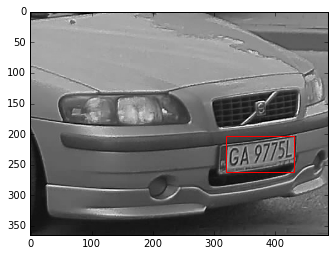

In [112]:
row = plates.loc[284]
print(row.image)
image_color = skimage.io.imread(INPUT_FOLDER + row.values[0])
image_gray = skimage.color.rgb2gray(image_color)
plot_record(image_gray, row[['x1', 'y1', 'x2', 'y2']].values)